# Symbol-level simulation
Let's first consider a simple symbol-level simulation. We consider a single-input
multiple-output (SIMO) system. First, we generate the transmit symbols
$$\mathbf{x}$$ based on i.i.d complex Gaussian distribution with zero mean and variance 1.
Then, we consider a single path channel $\mathbf{w}$ with i.i.d uniform phase in
$[0,2\pi]$. For the receiver, we consider $n_\mathrm{rx}=16$ receive antennas.
For each design option $\theta$ we create a different radio-frequency front-end (RFFE),
that can be described by a unique non-linear function $\Phi_\theta$.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

in_df = pd.read_csv(r'../datasets/rx_1/idata_1.csv')
p0_df = pd.read_csv(r'../datasets/rx_1/param_0_1_1.csv')
p1_df = pd.read_csv(r'../datasets/rx_1/param_1_1_1.csv')

In [100]:
fc = float(p0_df['fc'])
fs = float(p0_df['fs'])
nit = int(p0_df['nit'])
nrx = int(p0_df['nrx'])
nsnr = int(p0_df['nsnr'])
nx = int(p0_df['nx'])
ndsgn = 4;

In [101]:
# Random tx data
x = np.char.replace(np.array(in_df['x'],dtype=str),'i','j').astype(np.complex)

# Channel w
tmp = []
for i in range(1,nrx+1):
  tmp.append(np.char.replace(np.array(in_df['w_'+str(i)],dtype=str),'i','j').astype(np.complex))

w = np.empty([nx, nrx], dtype=complex)
for irx in range(nrx):
  w[:,irx] = tmp[irx]

# Received data with no noise
tmp = []
for i in range(1,nrx+1):
  tmp.append(np.char.replace(np.array(in_df['y_'+str(i)],dtype=str),'i','j').astype(np.complex))

y = np.empty([nx, nrx], dtype=complex)
for irx in range(nrx):
  y[:,irx] = tmp[irx]


# Received data at the antenna at various rx power levels
tmp = []
for i in range(1,nsnr*nrx+1):
  tmp.append(np.char.replace(np.array(in_df['yant_'+str(i)],dtype=str),'i','j').astype(np.complex))

r = np.empty([nx, nrx, nsnr], dtype=complex)
for isnr in range(nsnr):
  for irx in range(nrx):
    r[:,irx,isnr] = tmp[isnr*nrx + irx]

In [102]:
# Output of the RFFE non-linear function Phi(r)

y_rffe = np.empty([nx, nrx, nsnr, ndsgn], dtype=complex)
x_hat = np.empty([nx, nsnr, ndsgn], dtype=complex)

for idsgn in range(ndsgn):
  out_df = pd.read_csv(r'../datasets/rx_1/odata_'+str(idsgn+1)+'_1.csv')

  tmp = []
  for i in range(1,nsnr*nrx+1):
    tmp.append(np.char.replace(np.array(out_df['yrffe_'+str(i)],dtype=str),'i','j').astype(np.complex))

  for isnr in range(nsnr):
    for irx in range(nrx):
      y_rffe[:,irx,isnr,idsgn] = tmp[isnr*nrx + irx]

  # Predicted tx data
  tmp = []
  for i in range(1,nsnr+1):
    tmp.append(np.char.replace(np.array(out_df['xhat_'+str(i)],dtype=str),'i','j').astype(np.complex))

  for isnr in range(nsnr):
      x_hat[:,isnr,idsgn] = tmp[isnr]

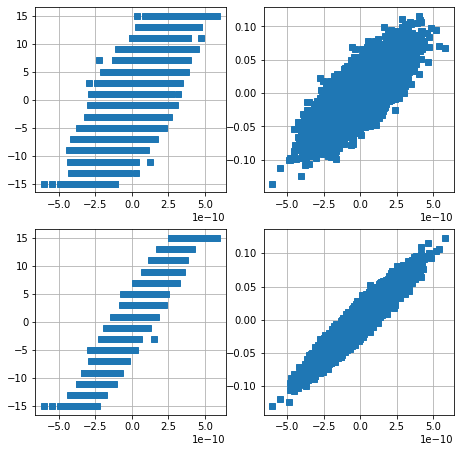

In [103]:
irx = 0
isnr = 10
plt.rcParams["figure.figsize"] = (7.5, 7.5)
for idsgn in range(ndsgn):
  plt.subplot(2,2,idsgn+1)
  plt.plot(r[:,irx,isnr].real, y_rffe[:,irx,isnr,idsgn].real, 's')
  plt.grid()